# GCC-TDoA IQ Processing and Localization

## Overview
This notebook processes simulated IQ data files to perform Time Difference of Arrival (TDoA) localization using Generalized Cross-Correlation (GCC).

## Workflow
1. Load .iq files and metadata from `notebooks/output/{timestamp}/`
2. Visualize received signals
3. Run GCC on all receiver pairs to estimate TDoA
4. Solve hyperbolic multilateration for transmitter position
5. Visualize results on map
6. Compare with ground truth (if available)


In [10]:
from __future__ import annotations

import sys
from pathlib import Path
import importlib

import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as cx
from shapely.geometry import Point

# Ensure matplotlib renders inline
%matplotlib inline

# Add repo root to path using relative navigation from notebook location
NOTEBOOK_DIR = Path.cwd()
REPO_ROOT = NOTEBOOK_DIR.parent.parent
sys.path.insert(0, str(REPO_ROOT))

# Reload all modules to pick up changes
import src.core.gcc
import src.core.iq_handler
import src.core.tdoa
import src.core.utils
import src.core

importlib.reload(src.core.gcc)
importlib.reload(src.core.iq_handler)
importlib.reload(src.core.tdoa)
importlib.reload(src.core.utils)
importlib.reload(src.core)

from src.core import (
    gcc_phat,
    compute_tdoa_from_gcc,
    load_iq_dataset,
    solve_tdoa_pairwise,
    get_bounds,
    match_fig_aspect,
    lonlat_to_xy_m,
    xy_m_to_lonlat,
)
from simulation.tdoa_sim import all_pairs


c = 299792458  # Speed of light (m/s)

print("All modules loaded successfully")


All modules loaded successfully


## 1. Load Dataset

Specify the path to your output directory from the signal generation notebook.

In [11]:
# Specify your data directory (modify timestamp as needed)
DATA_DIR = NOTEBOOK_DIR / "data" / "output" / "18_05_19_01"

print(f"Loading data from: {DATA_DIR.name}\n")

# Load the dataset
rx_signals, metadata = load_iq_dataset(DATA_DIR)

fs = metadata['fs']
n_rx = len(rx_signals)
receivers = metadata['receivers']  # Shape: (n_rx, 2) as [lon, lat]
tx_true = metadata['tx_pos']  # [lon, lat] or None

print(f"\nSuccessfully loaded {n_rx} receivers")
print(f"  Sample rate: {fs:.0f} Hz")
print(f"  Samples per packet: {metadata['n_samples']}")
print(f"  Packets per file: {metadata['n_packets']}")
print(f"\nReceiver positions:")
for i, (lon, lat) in enumerate(receivers):
    print(f"  RX{i}: {lat:.8f}N, {lon:.8f}E")
if tx_true is not None:
    print(f"\nGround truth TX: {tx_true[1]:.8f}N, {tx_true[0]:.8f}E")


Loading data from: 18_05_19_01


Successfully loaded 4 receivers
  Sample rate: 2000000 Hz
  Samples per packet: 362
  Packets per file: 1440

Receiver positions:
  RX0: 50.92200000N, 34.80000000E
  RX1: 50.92200000N, 34.81425036E
  RX2: 50.93098311N, 34.81425036E
  RX3: 50.93098311N, 34.80000000E

Ground truth TX: 50.90607389N, 34.83758859E


## 3. Visualize Received Signals

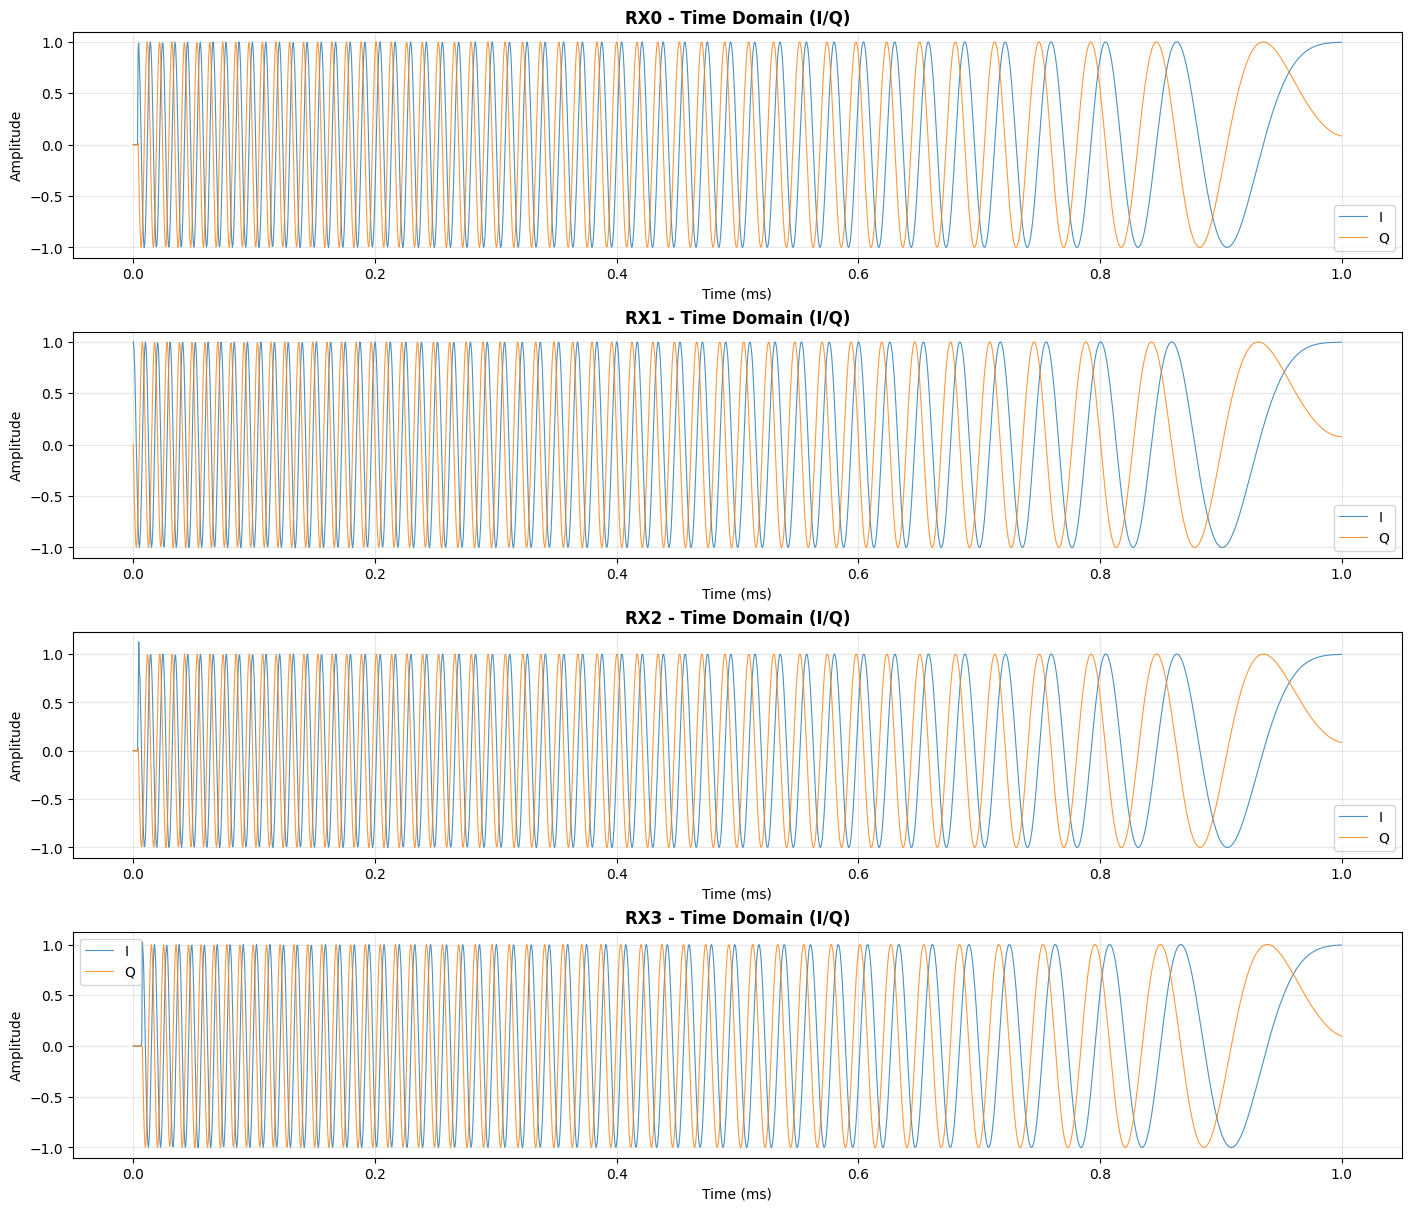

Signal visualization complete


In [12]:
# Visualize time-domain signals
n_show = min(2000, len(rx_signals[0]))
t_ms = (np.arange(n_show) / fs) * 1e3

fig, axs = plt.subplots(n_rx, 1, figsize=(14, 3 * n_rx), constrained_layout=True)
if n_rx == 1:
    axs = [axs]

for i in range(n_rx):
    axs[i].plot(t_ms, rx_signals[i].real[:n_show], label="I", linewidth=0.8, alpha=0.8)
    axs[i].plot(t_ms, rx_signals[i].imag[:n_show], label="Q", linewidth=0.8, alpha=0.8)
    axs[i].set_title(f"RX{i} - Time Domain (I/Q)", fontweight='bold')
    axs[i].set_xlabel("Time (ms)")
    axs[i].set_ylabel("Amplitude")
    axs[i].grid(True, alpha=0.3)
    axs[i].legend()

plt.show()

print("Signal visualization complete")


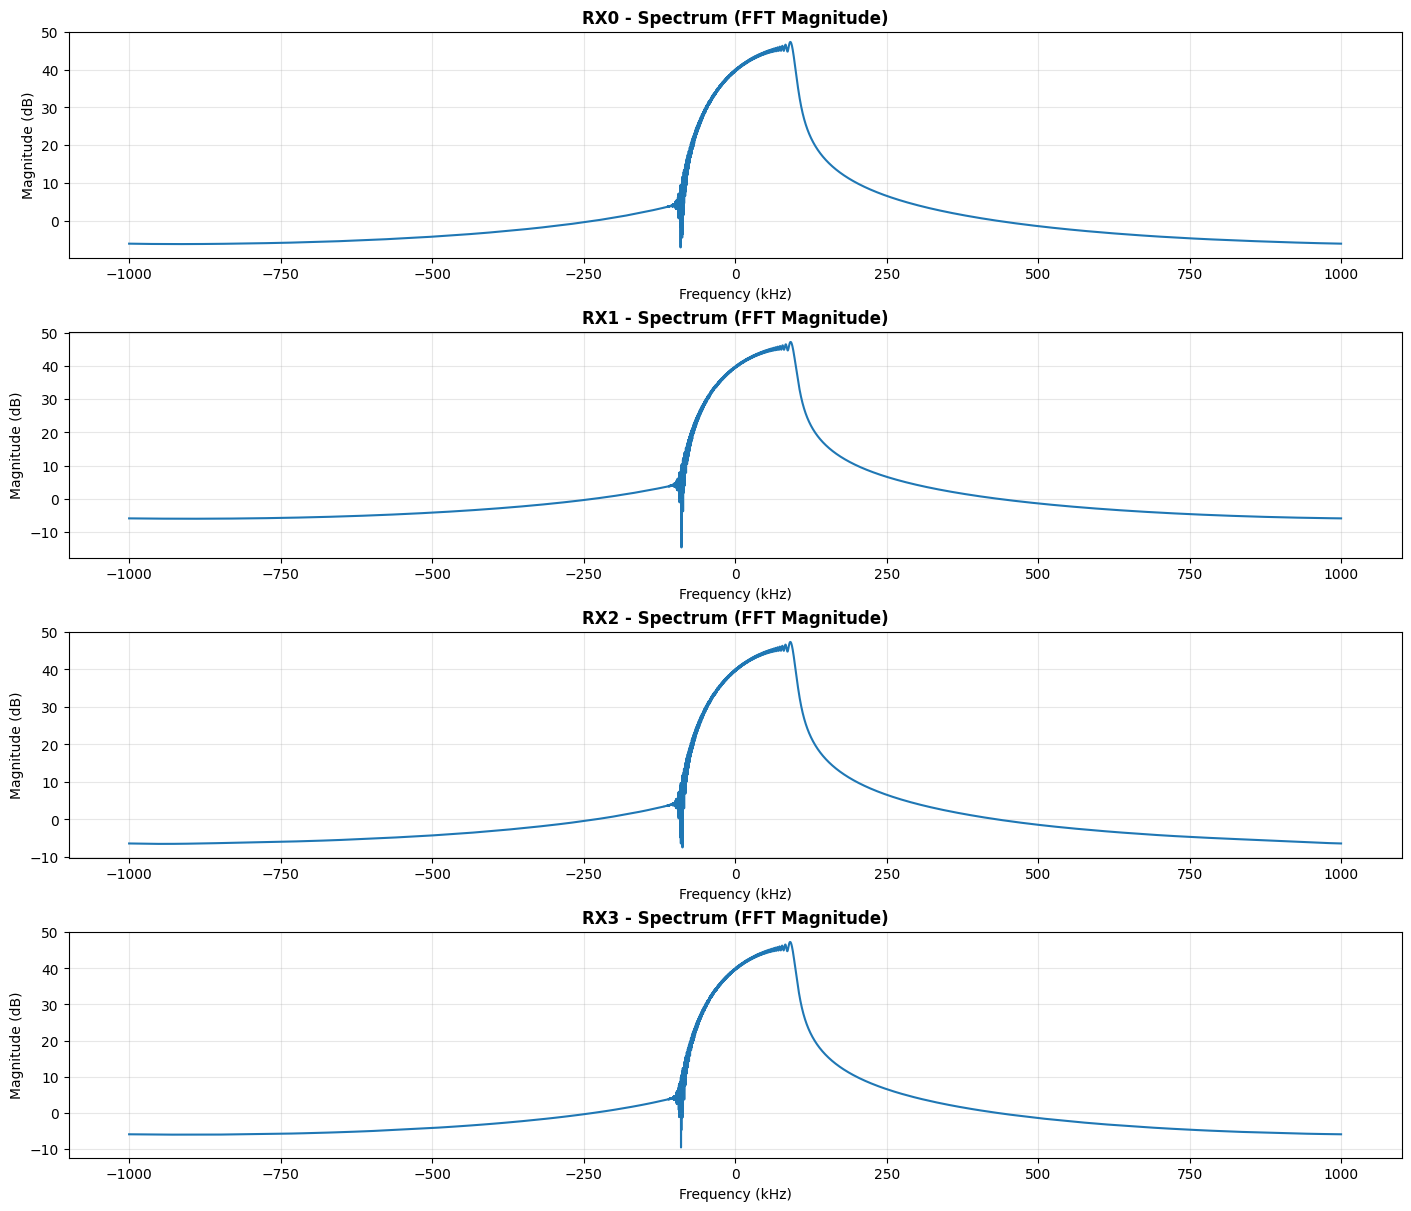

Spectrum visualization complete


In [13]:
# Visualize spectrum for each receiver
n_fft = 8192

fig, axs = plt.subplots(n_rx, 1, figsize=(14, 3 * n_rx), constrained_layout=True)
if n_rx == 1:
    axs = [axs]

for i in range(n_rx):
    # Apply window
    n_win = min(n_fft, len(rx_signals[i]))
    w = np.hanning(n_win)
    sig_windowed = rx_signals[i][:n_win] * w
    
    # Compute FFT
    X = np.fft.fftshift(np.fft.fft(sig_windowed, n=n_fft))
    f = np.fft.fftshift(np.fft.fftfreq(n_fft, d=1.0 / fs))
    
    # Plot magnitude spectrum
    axs[i].plot(f / 1e3, 20 * np.log10(np.maximum(np.abs(X), 1e-12)))
    axs[i].set_title(f"RX{i} - Spectrum (FFT Magnitude)", fontweight='bold')
    axs[i].set_xlabel("Frequency (kHz)")
    axs[i].set_ylabel("Magnitude (dB)")
    axs[i].grid(True, alpha=0.3)

plt.show()

print("Spectrum visualization complete")


## 2. GCC Processing - Compute TDoA for All Pairs

In [14]:
print(f"GCC Processing Configuration:")
print(f"  Number of receiver pairs: {len(all_pairs(n_rx))}")
print()

pairs = all_pairs(n_rx)

tdoa_measurements = {}
gcc_results = {}

for i, j in pairs:
    corr, lags = gcc_phat(rx_signals[i], rx_signals[j], fs)
    
    peak_idx = np.argmax(np.abs(corr))
    delay_samples = lags[peak_idx]
    tdoa_sec = delay_samples / fs
    
    tdoa_measurements[(i, j)] = tdoa_sec
    gcc_results[(i, j)] = (corr, lags)
    
    print(f"  Pair RX{i}-RX{j}: TDoA = {tdoa_sec * 1e6:>8.3f} us (delay = {delay_samples} samples)")

print("\nGCC processing complete")


GCC Processing Configuration:
  Number of receiver pairs: 6

  Pair RX0-RX1: TDoA =    4.000 us (delay = 8 samples)
  Pair RX0-RX2: TDoA =    0.000 us (delay = 0 samples)
  Pair RX0-RX3: TDoA =   -3.500 us (delay = -7 samples)
  Pair RX1-RX2: TDoA =    0.000 us (delay = 0 samples)
  Pair RX1-RX3: TDoA =   -7.500 us (delay = -15 samples)
  Pair RX2-RX3: TDoA =   -3.000 us (delay = -6 samples)

GCC processing complete


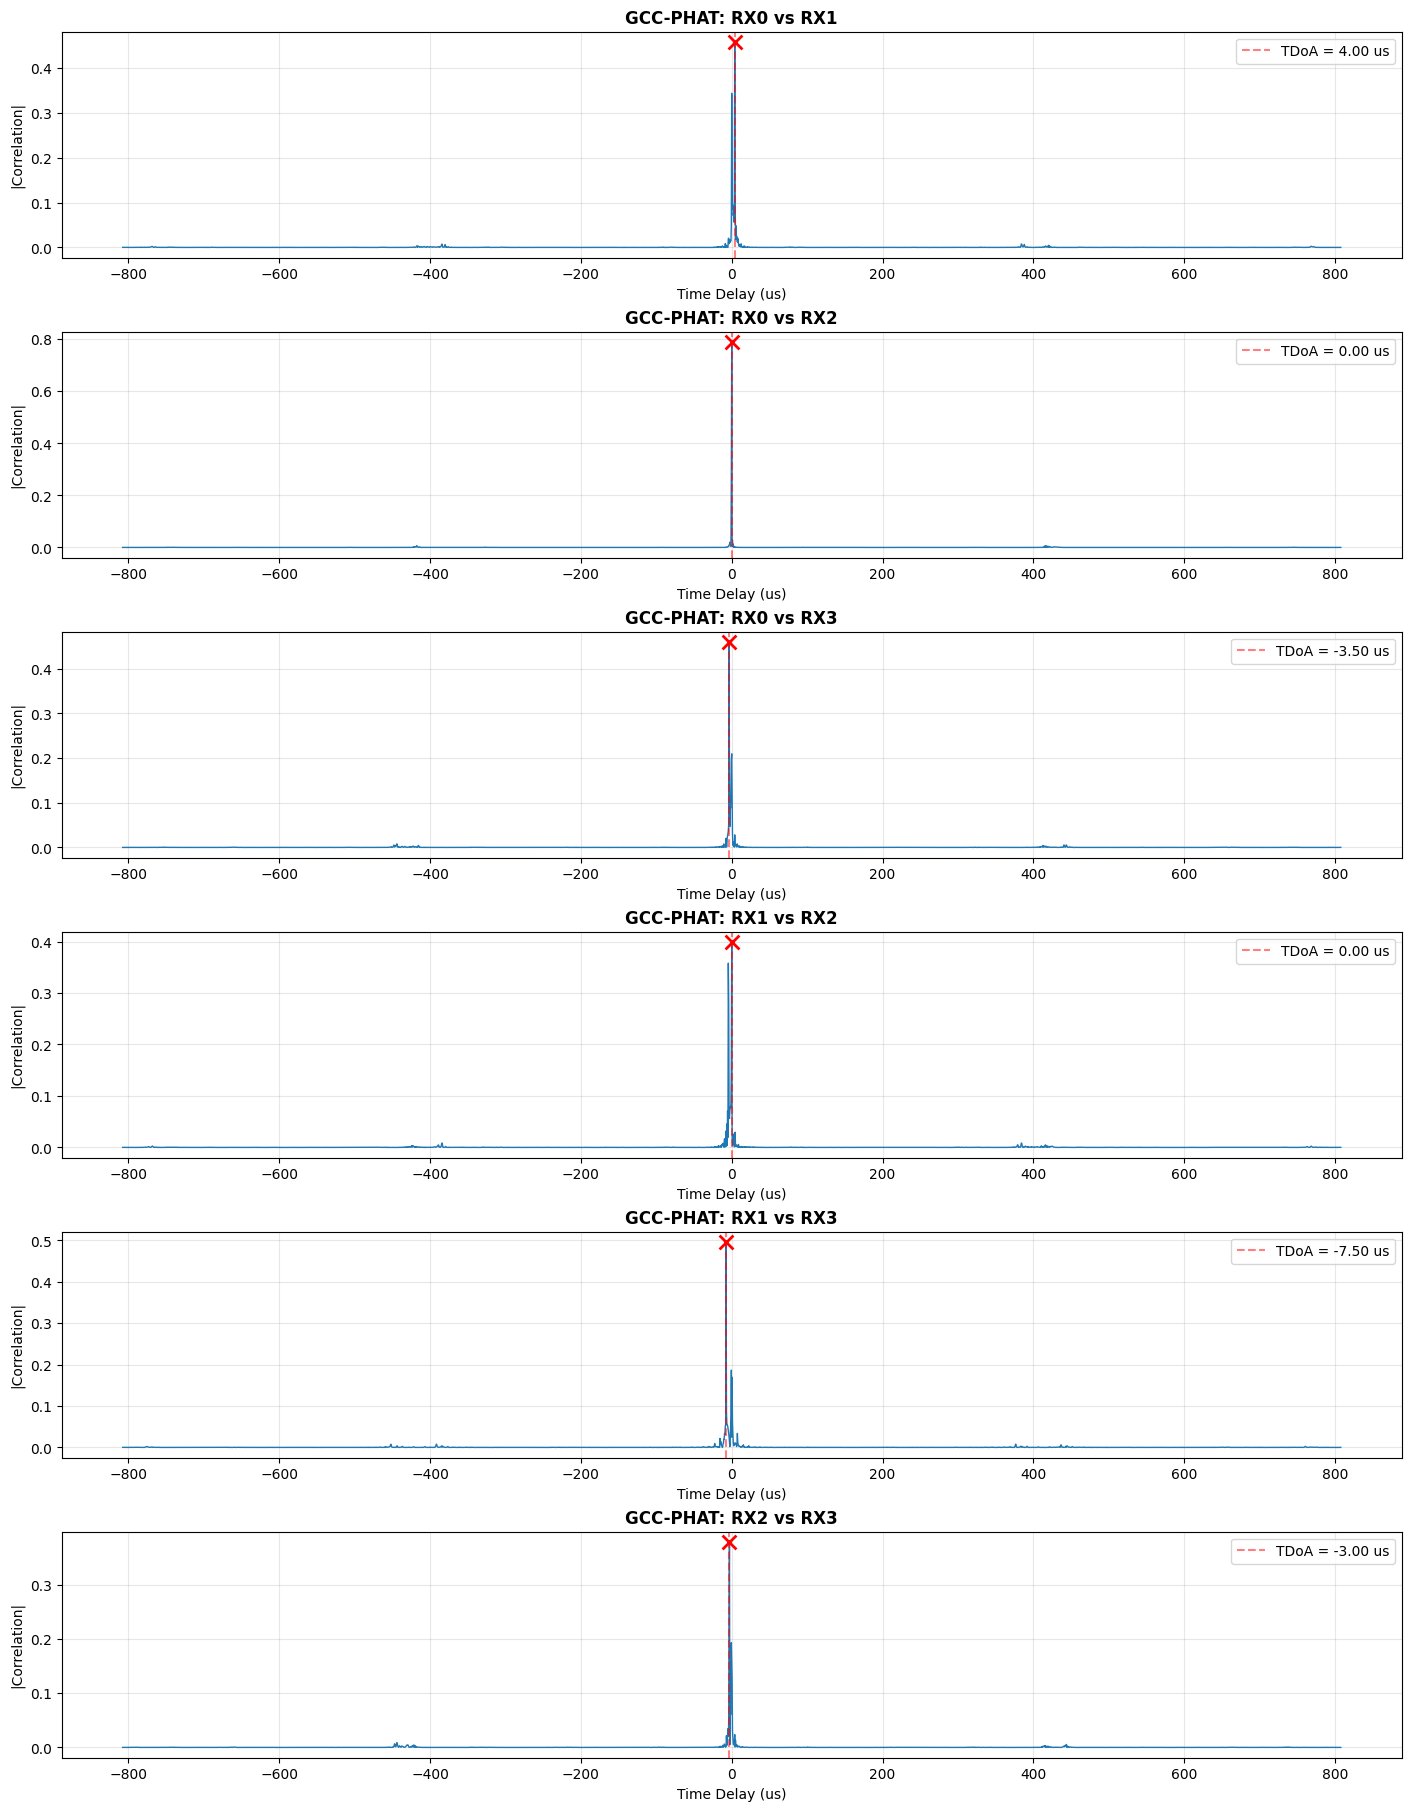

GCC visualization complete


In [15]:
# Visualize GCC correlation peaks
n_pairs = len(pairs)
fig, axs = plt.subplots(n_pairs, 1, figsize=(14, 3 * n_pairs), constrained_layout=True)
if n_pairs == 1:
    axs = [axs]

for idx, (i, j) in enumerate(pairs):
    corr, lags = gcc_results[(i, j)]
    tdoa_sec = tdoa_measurements[(i, j)]
    
    time_us = (lags / fs) * 1e6
    
    axs[idx].plot(time_us, np.abs(corr), linewidth=1)
    
    peak_idx = np.argmax(np.abs(corr))
    axs[idx].scatter([time_us[peak_idx]], [np.abs(corr[peak_idx])], 
                     c='red', s=100, zorder=5, marker='x', linewidths=2)
    axs[idx].axvline(tdoa_sec * 1e6, color='red', linestyle='--', alpha=0.5, 
                     label=f'TDoA = {tdoa_sec*1e6:.2f} us')
    
    axs[idx].set_title(f"GCC-PHAT: RX{i} vs RX{j}", fontweight='bold')
    axs[idx].set_xlabel("Time Delay (us)")
    axs[idx].set_ylabel("|Correlation|")
    axs[idx].grid(True, alpha=0.3)
    axs[idx].legend()

plt.show()

print("GCC visualization complete")


## 4. TDoA Localization - Solve for Transmitter Position

In [16]:
# Convert receivers to meters
receivers_xy = lonlat_to_xy_m(receivers)

print("Solving TDoA localization...\n")

# Prepare pairs in format for solve_tdoa_pairwise: (i, j, dt_seconds)
tdoa_pairs = [(i, j, tdoa_measurements[(i, j)]) for i, j in pairs]

# Solve for transmitter position using existing function
tx_estimated_xy, result = solve_tdoa_pairwise(receivers_xy, tdoa_pairs, c=c)

print(f"  Optimization success: {result.success}")
print(f"  Cost (final residual): {result.cost:.6f}")

# Convert back to lon/lat
tx_estimated_lonlat = xy_m_to_lonlat(tx_estimated_xy)[0]

print(f"\nEstimated TX Position:")
print(f"  Longitude: {tx_estimated_lonlat[0]:.8f}")
print(f"  Latitude:  {tx_estimated_lonlat[1]:.8f}")
print(f"  Meters (EPSG:3857): ({tx_estimated_xy[0]:.2f}, {tx_estimated_xy[1]:.2f})")

# If ground truth available, compute error
if tx_true is not None:
    tx_true_xy = lonlat_to_xy_m(tx_true)[0]
    error_m = np.linalg.norm(tx_estimated_xy - tx_true_xy)
    
    print(f"\nGround Truth Available:")
    print(f"  True TX Position: ({tx_true[0]:.8f}, {tx_true[1]:.8f})")
    print(f"  Localization Error: {error_m:.2f} meters")
else:
    print(f"\nNo ground truth available for comparison")

print("\nTDoA localization complete")


Solving TDoA localization...

  Optimization success: True
  Cost (final residual): 1349.470243

Estimated TX Position:
  Longitude: 34.86021477
  Latitude:  50.89301970
  Meters (EPSG:3857): (3880621.36, 6602391.92)

Ground Truth Available:
  True TX Position: (34.83758859, 50.90607389)
  Localization Error: 3413.67 meters

TDoA localization complete


## 5. Geographic Visualization

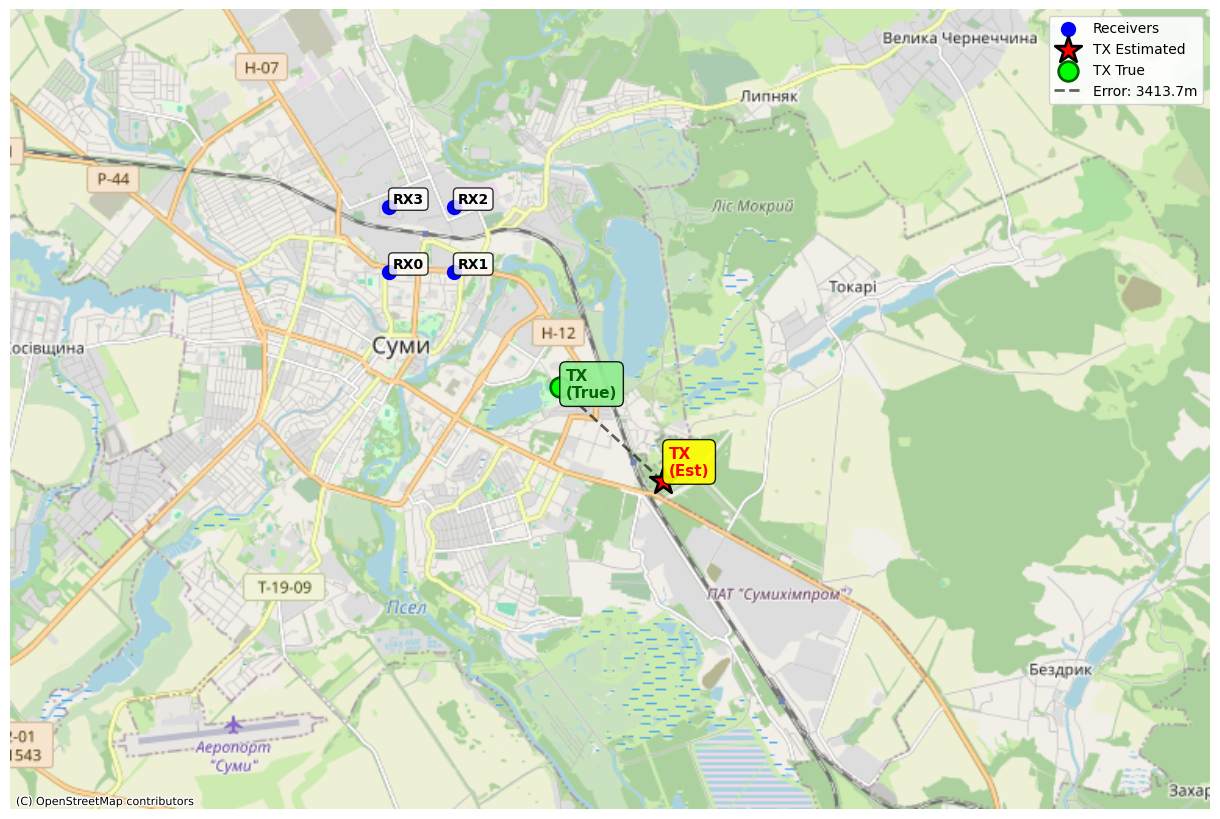

Map visualization complete


In [17]:
# Prepare points for visualization
extra_points = [tx_estimated_xy]
if tx_true is not None:
    tx_true_xy = lonlat_to_xy_m(tx_true)[0]
    extra_points.append(tx_true_xy)

# Calculate bounds
xmin, xmax, ymin, ymax = get_bounds(receivers_xy, extra_points=extra_points)

# Create map
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_position([0, 0, 1, 1])

# Plot receivers
receivers_gdf = gpd.GeoDataFrame(
    geometry=[Point(xy[0], xy[1]) for xy in receivers_xy],
    crs="EPSG:3857"
)
receivers_gdf.plot(ax=ax, color='blue', markersize=100, zorder=5, label='Receivers')
for k, p in enumerate(receivers_gdf.geometry):
    ax.text(p.x + 100, p.y + 100, f"RX{k}", zorder=6, fontsize=10, weight='bold',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# Apply aspect ratio correction
xmin, xmax, ymin, ymax = match_fig_aspect(
    xmin, xmax, ymin, ymax,
    fig.get_figwidth(), fig.get_figheight()
)

# Set bounds BEFORE adding basemap
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_aspect("auto")

# Add basemap
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, reset_extent=False)
ax.set_axis_off()

# Plot estimated TX position
ax.scatter([tx_estimated_xy[0]], [tx_estimated_xy[1]], marker="*", s=400, c="red",
          edgecolors="black", linewidths=2, zorder=10, label="TX Estimated")
ax.text(tx_estimated_xy[0] + 150, tx_estimated_xy[1] + 150, "TX\n(Est)", zorder=20,
       fontsize=11, weight="bold", color="red",
       bbox=dict(boxstyle="round,pad=0.4", facecolor="yellow", alpha=0.9))

# Plot true TX position if available
if tx_true is not None:
    ax.scatter([tx_true_xy[0]], [tx_true_xy[1]], marker="o", s=200, c="lime",
              edgecolors="darkgreen", linewidths=2, zorder=10, label="TX True")
    ax.text(tx_true_xy[0] + 150, tx_true_xy[1] - 250, "TX\n(True)", zorder=20,
           fontsize=11, weight="bold", color="darkgreen",
           bbox=dict(boxstyle="round,pad=0.4", facecolor="lightgreen", alpha=0.9))
    
    # Draw error line
    ax.plot([tx_estimated_xy[0], tx_true_xy[0]], 
           [tx_estimated_xy[1], tx_true_xy[1]],
           'k--', linewidth=2, alpha=0.6, label=f'Error: {error_m:.1f}m')

ax.legend(loc='upper right', fontsize=10, framealpha=0.9)

plt.show()

print("Map visualization complete")


## 6. Summary Report

In [18]:
print("="*70)
print("TDoA LOCALIZATION SUMMARY REPORT")
print("="*70)

print(f"\nData Directory: {DATA_DIR.name}")
print(f"\nSystem Configuration:")
print(f"  Number of Receivers: {n_rx}")
print(f"  Sample Rate: {fs:.0f} Hz")
print(f"  Signal Length: {len(rx_signals[0])} samples ({len(rx_signals[0])/fs*1000:.2f} ms)")

print(f"\nReceiver Positions (GPS):")
for i, (lon, lat) in enumerate(receivers):
    print(f"  RX{i}: {lat:.8f}N, {lon:.8f}E")

print(f"\nTDoA Measurements:")
for (i, j), tdoa in tdoa_measurements.items():
    print(f"  RX{i}-RX{j}: {tdoa*1e6:>8.3f} us")

print(f"\nLocalization Results:")
print(f"  Estimated Position: {tx_estimated_lonlat[1]:.8f}N, {tx_estimated_lonlat[0]:.8f}E")

if tx_true is not None:
    print(f"  True Position:      {tx_true[1]:.8f}N, {tx_true[0]:.8f}E")
    print(f"\nAccuracy Metrics:")
    print(f"  Horizontal Error: {error_m:.2f} meters")
    
    baseline_distances = []
    for i in range(n_rx):
        for j in range(i+1, n_rx):
            dist = np.linalg.norm(receivers_xy[i] - receivers_xy[j])
            baseline_distances.append(dist)
    avg_baseline = np.mean(baseline_distances)
    relative_error = (error_m / avg_baseline) * 100
    
    print(f"  Average Baseline: {avg_baseline:.2f} meters")
    print(f"  Relative Error: {relative_error:.2f}%")
    
    if error_m < 50:
        print(f"  Status: Excellent localization accuracy")
    elif error_m < 200:
        print(f"  Status: Good localization accuracy")
    else:
        print(f"  Status: Consider checking receiver geometry or signal quality")
else:
    print(f"  No ground truth available for comparison")

print("\n" + "="*70)
print("Processing Complete")
print("="*70)


TDoA LOCALIZATION SUMMARY REPORT

Data Directory: 18_05_19_01

System Configuration:
  Number of Receivers: 4
  Sample Rate: 2000000 Hz
  Signal Length: 521280 samples (260.64 ms)

Receiver Positions (GPS):
  RX0: 50.92200000N, 34.80000000E
  RX1: 50.92200000N, 34.81425036E
  RX2: 50.93098311N, 34.81425036E
  RX3: 50.93098311N, 34.80000000E

TDoA Measurements:
  RX0-RX1:    4.000 us
  RX0-RX2:    0.000 us
  RX0-RX3:   -3.500 us
  RX1-RX2:    0.000 us
  RX1-RX3:   -7.500 us
  RX2-RX3:   -3.000 us

Localization Results:
  Estimated Position: 50.89301970N, 34.86021477E
  True Position:      50.90607389N, 34.83758859E

Accuracy Metrics:
  Horizontal Error: 3413.67 meters
  Average Baseline: 1805.46 meters
  Relative Error: 189.07%
  Status: Consider checking receiver geometry or signal quality

Processing Complete
